In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from random import randint
from random import seed
from scipy.signal import savgol_filter
from scipy.signal import argrelextrema
#from tslearn.clustering import TimeSeriesKMeans
import warnings
warnings.filterwarnings('ignore')

In [4]:
ndvi = pd.read_csv("C:/Users/User/Documents/NOA/e-shape/e-shape_Data/satellite_data_from_NOA/featurespace_object_NDVI.csv", header=0)

In [4]:
ndvi.columns.values[1:] = [1,6,16,26,31,36,66,71,86,91,96,111,116,121,136,141,146,151,156,161,166,171,176,181,186,191,
                          196,201,206,211,216,221,226,231,236,241,246,251,256,261,266,271,281,291,306,314,316,336,341,361]
obj_ids = ndvi.iloc[:,0]
del ndvi['id']
ndvi = ndvi.replace(-9999999, -999999)
ndvi = ndvi.replace(np.nan, -999999)
new_days = ["2018-01-10", "2018-01-20", "2018-01-30", "2018-02-10", "2018-02-20", "2018-02-28","2018-03-10", "2018-03-20", 
            "2018-03-30", "2018-04-10", "2018-04-20", "2018-04-30", "2018-05-10", "2018-05-20", "2018-05-30", "2018-06-10", 
            "2018-06-20", "2018-06-30", "2018-07-10", "2018-07-20", "2018-07-30", "2018-08-10", "2018-08-20", "2018-08-30", 
            "2018-09-10", "2018-09-20", "2018-09-30", "2018-10-10", "2018-10-20", "2018-10-30", "2018-11-10", "2018-11-20",
            "2018-11-30","2018-12-10","2018-12-20","2018-12-30"]
ndvi = ndvi.T
ndvi.index.name = 'doys' #Create decadal dates to have a fixed timestep
ndvi.reset_index(inplace=True)
nd = list()
for i in range(len(new_days)):
    nd.append(datetime.strptime(new_days[i], '%Y-%m-%d').timetuple().tm_yday)
ndvi=ndvi[1:ndvi.shape[0]]

In [5]:
ndvinn = ndvi.drop(['doys'], axis=1)
ndvinn.index = ndvi.doys
ndvinn = ndvinn.replace(-999999, np.nan)
ndvinn = ndvinn.replace(-9999999, np.nan)
l=np.zeros(shape=(ndvinn.shape[0],2))
for i in range(ndvinn.shape[0]):
    l[i,0] = np.nanstd(ndvinn.iloc[i,:])
    l[i,1] = np.nanmean(ndvinn.iloc[i,:])
l = pd.DataFrame(l)
l.columns = ['std_l','mean_l']

#Find 99.7 of the data that are within +- 3std
l['lower_limit'] = (l.mean_l-3*l.std_l)
l['upper_limit'] = (l.mean_l+3*l.std_l)
l = pd.DataFrame(l)
l.index = ndvinn.index
outliers = []
for i in range(ndvinn.shape[0]):
    for j in range(ndvinn.shape[1]):
        if((ndvinn.iloc[i,j]<l.iloc[i,2]) or (ndvinn.iloc[i,j]>l.iloc[i,3])):
            outliers.append(ndvinn.iloc[i,j])
            ndvinn.iloc[i,j] = np.nan
print('--- Number of total outliers found: %s ---'%len(outliers))
ndvinn.insert (0, 'doys', ndvinn.index)
ndvinn.index = range(0,ndvinn.shape[0])
ndvinn = ndvinn.replace(np.nan,-999999)
ndvi = ndvinn.copy()

--- Number of total outliers found: 22 ---


In [6]:
ndvi = ndvi.replace(np.nan,-999999)
#Weighted Average Interpolation, search +-5 days to find the reference days 
#from which the new dates will be created
l = np.zeros(ndvi.shape[0])
for i in range(ndvi.shape[0]):
    for j in range(len(nd)):
        x = ndvi.iloc[i,0]
        y = nd[j]
        if (abs(x-y) <= 5):
            l[i] = y
ndvi = pd.concat([pd.DataFrame(l),ndvi.reset_index(drop=True)], axis=1) #
ndvi.columns.values[0] = 'ref'
del new_days,nd
colnames = ndvi.columns.values
def interp_weight (df):
    dfn = np.zeros(shape=(df.shape[0],df.shape[1]))    
    #colnames = df.columns.values
    i = 0
    while (i <= (df.shape[0]-1)):
        if (i == (df.shape[0]-1)):
            dfn[i,:] = df[i,:] #When i becomes the last row then import the last row
            i=i+1
        elif (df[i,0] != df[i+1,0]):
            dfn[i,:] = df[i,:] #If value of ref at i is different at value of ref at i+1 then import the i line 
            i=i+1        
        else:
            if (df[i,0] == df[i,1]): #If value of ref at i is equal to value of doys at the same line i then import i line
                dfn[i,:] = df[i,:]
                i=i+2
            elif (df[i+1,0] == df[i+1,1]): #If value of ref at i+1 is equal to value of doys at the i+1 line import i+1 line 
                dfn[i,:] = df[i+1,:]
                i=i+2
            else:
                diff = df[i+1,1] - df[i,1]
                dist = abs(df[i,1] - df[i,0])
                w = (diff-dist)/diff
                df[i,:][df[i,:]==(-999999)] = df[i+1,:][df[i,:]==(-999999)]
                df[i+1,:][df[i+1,]==(-999999)] = df[i,:][df[i+1,:]==(-999999)]
                new_row = w*df[i,:] + (1-w)*df[i+1,] 
                dfn[i,:] = new_row
                i = i + 2    
    #dfn.columns = colnames
    return pd.DataFrame(dfn)
ndvi = np.array(ndvi)
ndvi = interp_weight(ndvi)
ndvi.columns = colnames
ndvi = ndvi.replace(-999999.0000000001, np.nan)
ndvi = ndvi.replace(-999999.0, np.nan)
ndvi = ndvi.drop(['doys'], axis=1)
del colnames
d = list()
for i in range(ndvi.shape[0]):
    if (ndvi.iloc[i,0]==0):
        d.append(i)      
ndvi = ndvi.drop(d, axis=0)  
del d
ndvi = ndvi.drop(ndvi.index[16])
ndvi.index = ndvi.ref
ndvi = ndvi.drop(['ref'], axis=1)
ndvin = ndvi.copy()

In [7]:
polynomial = np.zeros(shape=ndvin.shape)
obj_id = np.array(ndvin.columns)
#Apply Polynomial Interpolation second order, replace timeseries with less than 3 values with nan to remove them afterwards
time_with_less = []
for i in range(ndvin.shape[1]):
    if (len(ndvin.iloc[:,i].unique())>3):
        pd.DataFrame(polynomial).iloc[:,i] = pd.DataFrame(np.array(ndvin.iloc[:,i]).flatten()).interpolate(method ='polynomial', order=2).ffill().bfill()
    else:
        time_with_less.append(ndvin.columns[i])
        polynomial[:,i] = np.nan

In [8]:
print('Found %s timeseries with less than 3 values' %len(time_with_less))
polynomial = pd.DataFrame(polynomial)
polynomial.index = ndvin.index
###Apply again Outlier Detection with Normal Distribution
l = np.zeros(shape=(polynomial.shape[0],2))
for i in range(polynomial.shape[0]):
    l[i,0] = np.nanstd(polynomial.iloc[i,:])
    l[i,1] = np.nanmean(polynomial.iloc[i,:])
l = pd.DataFrame(l)
l.columns = ['std_l','mean_l']

#Find 99.7 of the data that are within +- 3std
l['lower_limit'] = (l.mean_l-3*l.std_l)
l['upper_limit'] = (l.mean_l+3*l.std_l)
l = pd.DataFrame(l)
l.index = polynomial.index
outliers = []
for i in range(polynomial.shape[0]):
    for j in range(polynomial.shape[1]):
        if((polynomial.iloc[i,j]<l.iloc[i,2]) or (polynomial.iloc[i,j]>l.iloc[i,3])):
            outliers.append(polynomial.iloc[i,j])
            polynomial.iloc[i,j] = np.nan 
print('--- Number of total outliers found: %s ---'%len(outliers))

Found 0 timeseries with less than 3 values
--- Number of total outliers found: 14 ---


In [9]:
new_doys = list(range(0,365))
old_doys = np.array(polynomial.index)
new_doys = np.array(new_doys)
ndvin = np.zeros(shape=(len(new_doys),polynomial.shape[1]))
ndvin[ndvin == 0] = 'nan'

In [10]:
for i in range(ndvin.shape[0]):
    if (i in old_doys):
        ndvin[i,:] = polynomial.loc[polynomial.index==i,:]
#ndvin[:,0] = range(0,365)
ndvin = pd.DataFrame(ndvin)
#ndvin.columns = obj_id
print('---Drop %s from %s timeseries with less than 3 values---' %(len(time_with_less) ,ndvin.shape[1]))

#ids = np.setdiff1d(np.union1d(obj_id, time_with_less), np.intersect1d(obj_id, time_with_less))
ndvin = ndvin.dropna(axis='columns', how='all')

---Drop 0 from 45 timeseries with less than 3 values---


In [11]:
linear = np.zeros(shape=ndvin.shape)

for i in range(ndvin.shape[1]):
    linear[:,i] = ndvin.iloc[:,i].interpolate(method ='linear', axis=0).ffill().bfill()

linear = pd.DataFrame(linear)
linear.columns = ndvin.columns

In [12]:
savitzky = np.zeros(shape=linear.shape)
for i in range(savitzky.shape[1]):
    savitzky[:,i] = savgol_filter(np.array(linear.iloc[0:,i]).reshape(linear.shape[0]),mode='nearest', 
                                  window_length = 51, polyorder = 4)
savitzky = pd.DataFrame(savitzky)
savitzky.index = range(0,savitzky.shape[0])

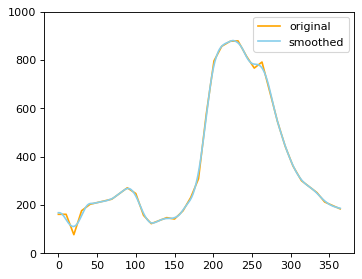

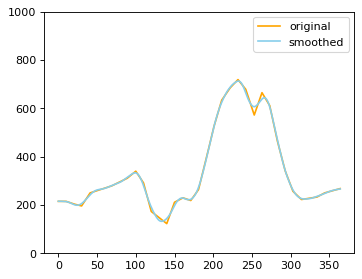

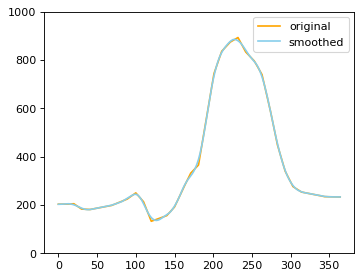

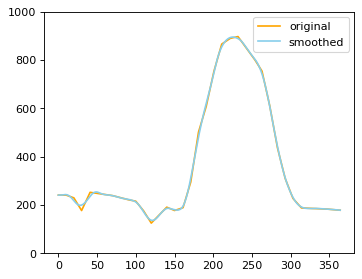

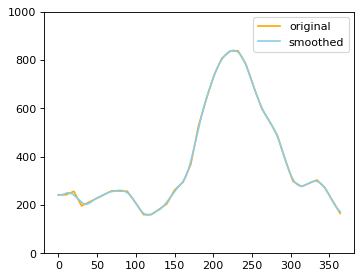

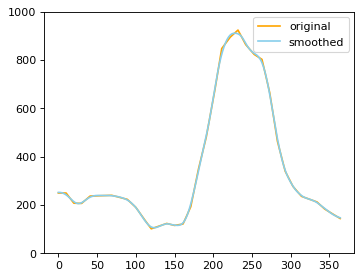

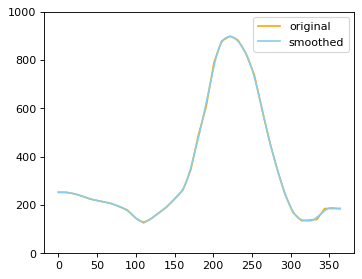

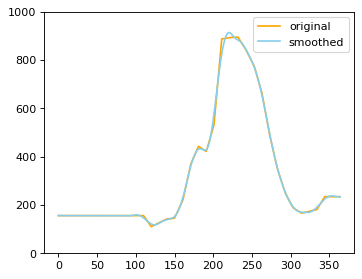

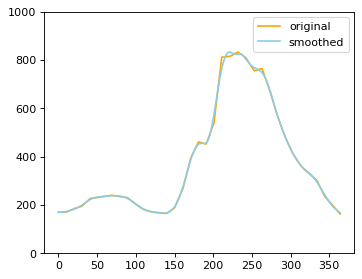

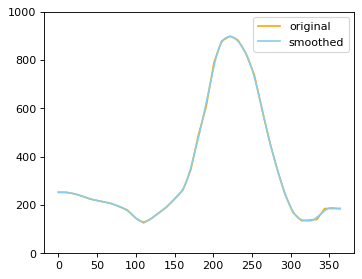

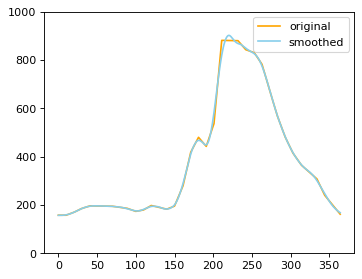

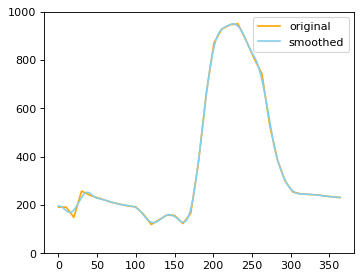

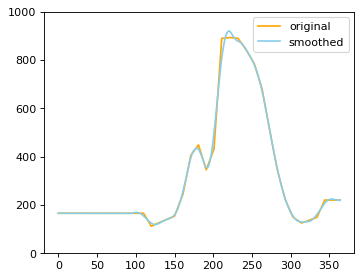

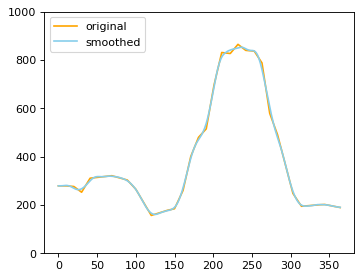

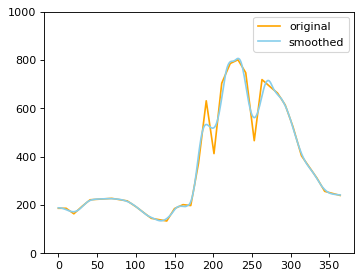

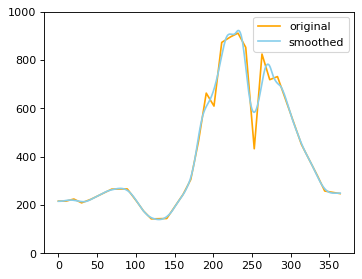

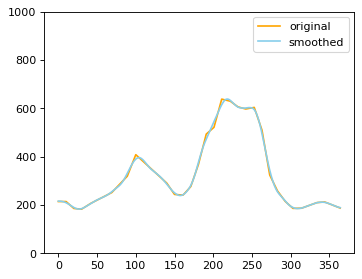

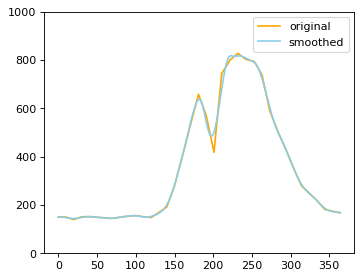

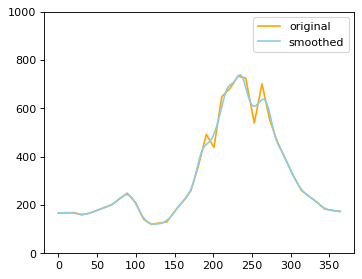

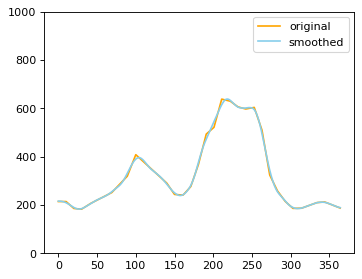

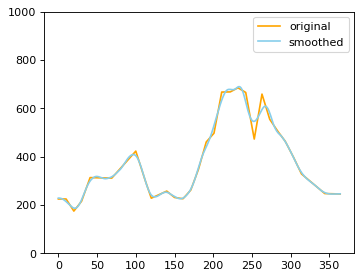

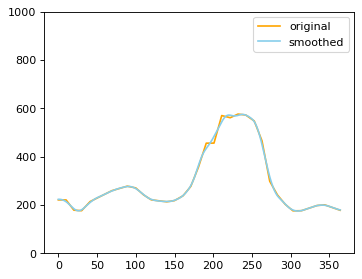

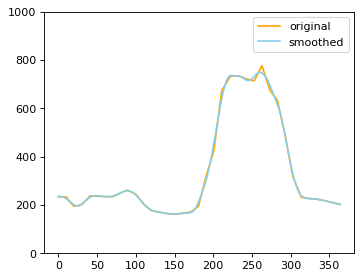

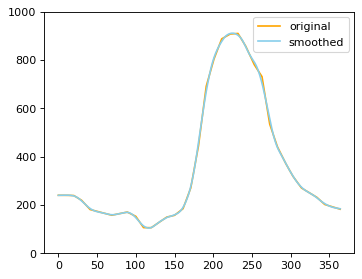

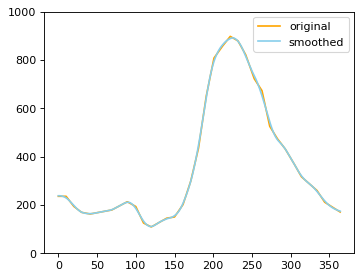

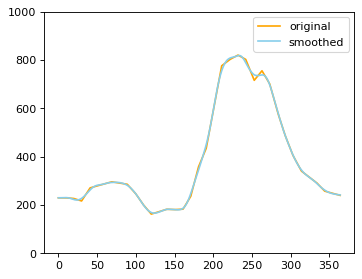

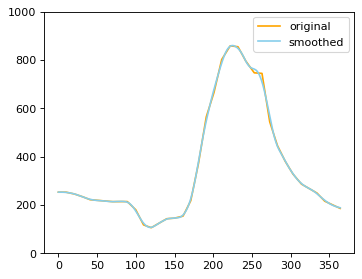

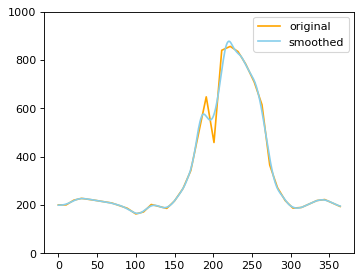

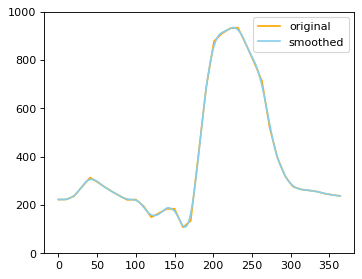

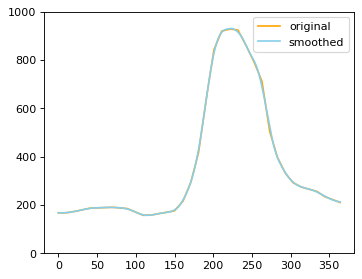

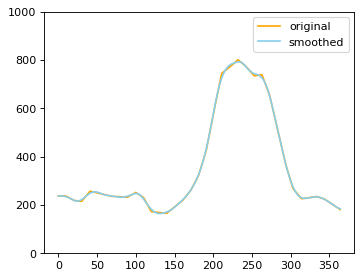

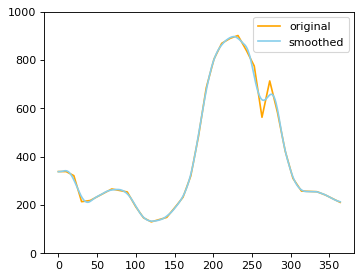

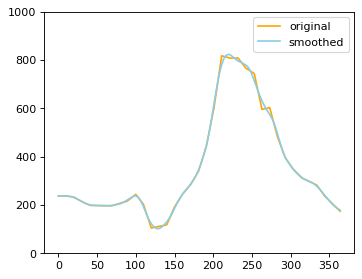

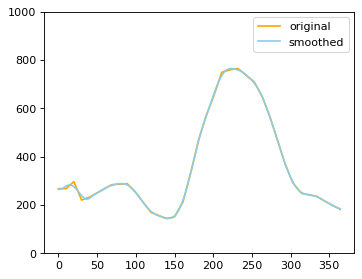

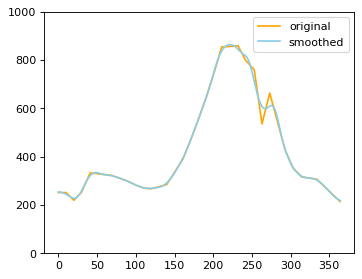

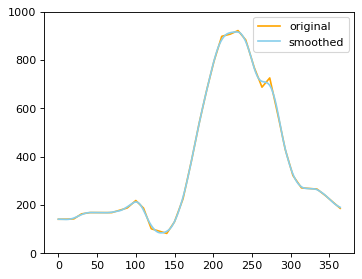

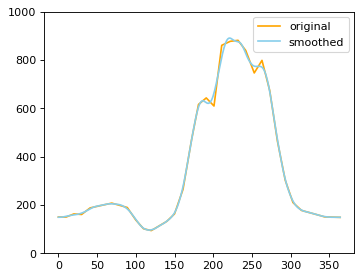

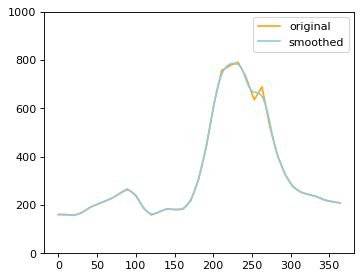

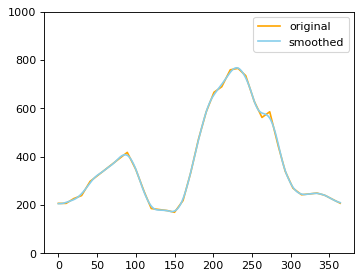

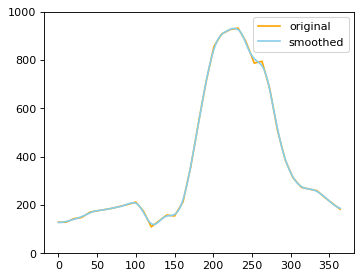

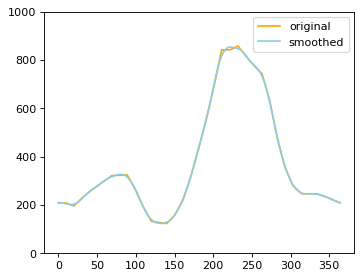

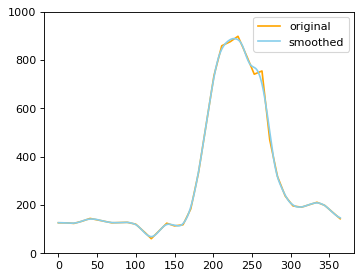

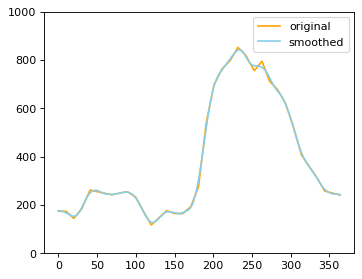

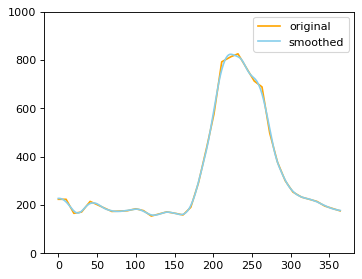

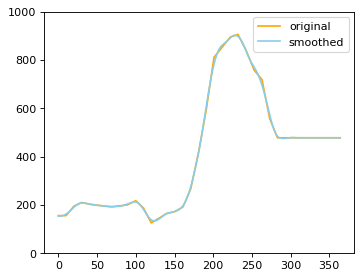

In [13]:
for a in range(savitzky.shape[1]):
    #a=2
    df1 = savitzky.iloc[0:,a].copy()
    df2 = linear.iloc[0:,a].copy()
    plt.figure(num=None, figsize=(5,4), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(df2, marker=None, markerfacecolor='orange', color='orange', label='original')
    plt.plot(df1, marker=None, markerfacecolor='skyblue', color='skyblue', label='smoothed')
    plt.ylim(0,1000)
    plt.legend()

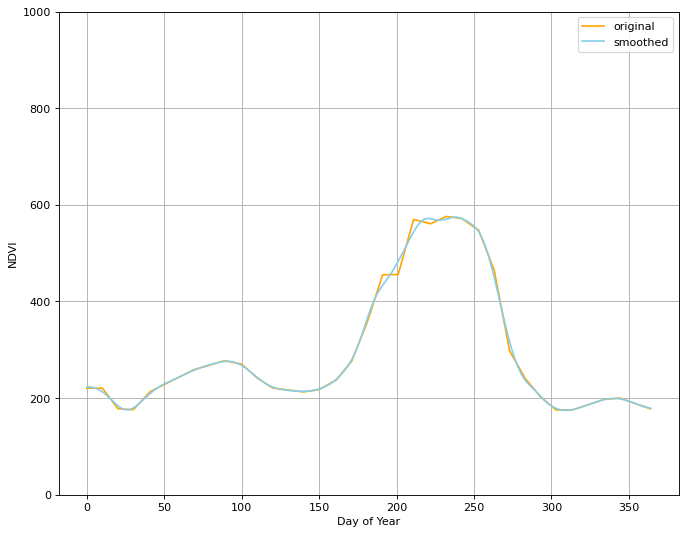

In [14]:
a=21
df1 = savitzky.iloc[0:,a].copy()
df2 = linear.iloc[0:,a].copy()
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df2, marker=None, markerfacecolor='orange', color='orange', label='original')
plt.plot(df1, marker=None, markerfacecolor='skyblue', color='skyblue', label='smoothed')
plt.ylim(0,1000)
plt.xlabel('Day of Year')
plt.ylabel('NDVI')
plt.grid()
plt.legend()

In [15]:
ndvi = savitzky.copy()

In [16]:
ndvi.columns = obj_ids
#ndvi.to_csv('ndvi_interpolated_rodopi.csv')

In [17]:
#Calculate local minima around peak value in order to define lag of moving average and therefore start/end of season
t_left_min = np.zeros(shape=(ndvi.shape[1],2))
t_right_min = np.zeros(shape=(ndvi.shape[1],2))

for i in range(ndvi.shape[1]):
#    print(i)
    if (ndvi.iloc[:,i].mean()>0):
        t_left_min[i,1] = ndvi.iloc[130:int(ndvi.iloc[:,i].idxmax()),i].min() #120
        t_left_min[i,0] = ndvi.iloc[130:int(ndvi.iloc[:,i].idxmax()),i].idxmin()
        
        t_right_min[i,1] = ndvi.iloc[int(ndvi.iloc[:,i].idxmax()):330,i].min()
        t_right_min[i,0] = ndvi.iloc[int(ndvi.iloc[:,i].idxmax()):330,i].idxmin()
    
t_left_min = pd.DataFrame(t_left_min)
t_right_min = pd.DataFrame(t_right_min)

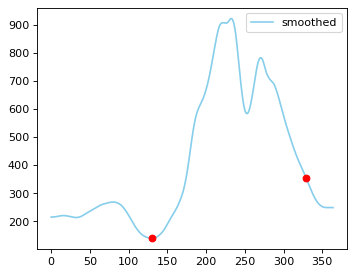

In [18]:
a=15
df1 = ndvi.iloc[0:,a]
minx = argrelextrema(np.array(ndvi.iloc[0:,a]), np.less) 
plt.figure(num=None, figsize=(5,4), dpi=80, facecolor='w', edgecolor='k')

plt.plot(df1, marker=None, markerfacecolor='skyblue', color='skyblue', label='smoothed')
plt.plot(t_left_min.iloc[a,0],t_left_min.iloc[a,1], marker='o', color='red')
plt.plot(t_right_min.iloc[a,0],t_right_min.iloc[a,1], marker='o', color='red')

plt.legend()

In [19]:
# local_minx = list()
# for i in range(ndvi.shape[1]):
#     local_minx.append(np.asarray(argrelextrema(np.array(ndvi.iloc[0:,i]), np.less, order=6))[0])

In [20]:
# local_miny = [[] for x in range(len(local_minx))]
# for i in range (len(local_minx)):
#     for j in range (len(local_minx[i])):
#         local_miny[i].append(np.asarray(ndvi.iloc[:,i][ndvi.iloc[:,i].index==local_minx[i][j]])[0])

In [21]:
# integrals = [[] for x in range(len(local_minx))]
# for i in range(ndvi.shape[1]):
#     for j in range(len(local_minx[i])-1):
#         a = np.array(ndvi.iloc[:,i][ndvi.iloc[:,i]==local_miny[i][j]].index)[0]
#         b = np.array(ndvi.iloc[:,i][ndvi.iloc[:,i]==local_miny[i][j+1]].index)[0]
#         integrals[i].append(np.round(np.trapz(ndvi.iloc[a:b,i]),2))

# maxintpos = list()
# for i in range(len(integrals)):
#     maxintpos.append(integrals[i].index(np.max(integrals[i])))

In [22]:
# t_left_min = np.zeros(shape=(ndvi.shape[1],2))
# t_right_min = np.zeros(shape=(ndvi.shape[1],2))
# for i in range(ndvi.shape[1]):
#     t_left_min[i,0] = local_minx[i][maxintpos[i]]
#     t_left_min[i,1] = np.array(ndvi.iloc[ndvi.iloc[:,i].index==local_minx[i][maxintpos[i]],0])[0]
#     t_right_min[i,0] = local_minx[i][maxintpos[i]+1]
#     t_right_min[i,1] = np.array(ndvi.iloc[ndvi.iloc[:,i].index==local_minx[i][maxintpos[i]+1],0])[0]

# t_left_min = pd.DataFrame(t_left_min)
# t_right_min = pd.DataFrame(t_right_min)

In [23]:
mstd_area = np.zeros(shape=(ndvi.shape[1],2))
for i in range(ndvi.shape[1]):
    if (ndvi.iloc[:,i].mean()>0):
        mstd_area[i,0] = np.mean(np.array(ndvi.iloc[(ndvi.index>=t_left_min.iloc[i,0]) & (ndvi.index<=t_right_min.iloc[i,0]),i].index))
        mstd_area[i,1] = np.std(np.array(ndvi.iloc[(ndvi.index>=t_left_min.iloc[i,0]) & (ndvi.index<=t_right_min.iloc[i,0]),i].index))
    else:
        mstd_area[i,0] = 0
        mstd_area[i,1] = 0
mstd_area = pd.DataFrame(mstd_area)
mstd_area.columns = ['mean','std']

In [24]:
t_min = pd.concat([t_left_min,t_right_min], axis=1)
t_min.columns = ['left_min_doy','left_min_val','right_min_doy','right_min_val']
t_min = pd.concat([t_min,mstd_area], axis=1)
t_min['SLE'] = np.round(t_min.iloc[:,5]*2,0)
t_min['lag'] = np.round(ndvi.shape[0] - t_min.iloc[:,6],0)
#t_min.lag = pd.DataFrame(np.round(t_min.lag/10,0))
ndvi = pd.concat([ndvi,ndvi,ndvi], axis=0)
ndvi.index = range(0,ndvi.shape[0])

In [25]:
rolling_mean_forw = np.zeros(shape = ndvi.shape)
rolling_mean_back = np.zeros(shape = ndvi.shape)
typew = 'boxcar'
#int(t_min.iloc[i,7])
#min_periods=1
for i in range(ndvi.shape[1]):
    rolling_mean_forw[:,i] = ndvi.iloc[:,i].rolling(window=int(t_min.iloc[i,7]), win_type=typew).mean()
    rolling_mean_back[:,i] = ndvi.iloc[:,i][::-1].rolling(window=int(t_min.iloc[i,7])).mean()[::-1].shift()

rolling_mean_forw = pd.DataFrame(rolling_mean_forw)
rolling_mean_back = pd.DataFrame(rolling_mean_back)

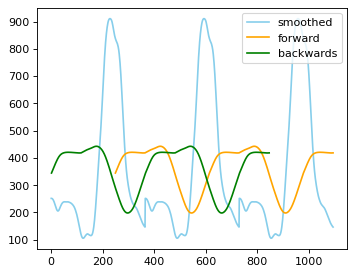

In [26]:
a=5
plt.figure(num=None, figsize=(5,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(ndvi.iloc[:,a], marker=None, markerfacecolor='skyblue', color='skyblue', label='smoothed')
plt.plot(rolling_mean_forw.iloc[:,a], color='orange', label='forward')
plt.plot(rolling_mean_back.iloc[:,a], color='green', label='backwards')
plt.legend()

In [27]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [28]:
#Calculate phenological metrics
pheno_metrics = np.zeros(shape=(ndvi.shape[1],3))

for i in range(ndvi.shape[1]):
    if (ndvi.iloc[:,i].mean()>0):
        int_f = np.argwhere(np.diff(np.sign(ndvi.iloc[:,i] - rolling_mean_forw.iloc[:,i]))).flatten()
        int_f = int_f[(int_f>110) & (int_f<200)]
        if (int_f.size!=0):
            pheno_metrics[i,0] = np.array(int_f[len(int_f)-1])
        
        pheno_metrics[i,1] = ndvi.iloc[:,i].idxmax()
        
        int_b = np.argwhere(np.diff(np.sign(ndvi.iloc[:,i] - rolling_mean_back.iloc[:,i]))).flatten()
        int_b = int_b[(int_b>250) & (int_b<360)]
        if (int_b.size!=0):
            pheno_metrics[i,2] = np.array(int_b[0])

pheno_metrics = pd.DataFrame(pheno_metrics)
pheno_metrics.columns = ['start','peak','end']
pheno_metrics = pheno_metrics.replace(0, np.nan)
pheno_metrics['len_seas'] = pheno_metrics.end-pheno_metrics.start
pheno_metrics['amplitude'] = (t_min.left_min_val+t_min.right_min_val)/2

In [29]:
pheno_metrics['rate_inc'] = np.zeros(shape=pheno_metrics.shape[0])
pheno_metrics['rate_dec'] = np.zeros(shape=pheno_metrics.shape[0])
for a in range(ndvi.shape[1]):
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.rate_inc[a] = np.nan
        
    else:
        pheno_metrics.rate_inc[a] = (np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,1],a])-np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,0],a]))/(np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,1],a].index)-np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,0],a].index))        

In [30]:
for a in range(ndvi.shape[1]):
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.rate_dec[a] = np.nan
    else:
        pheno_metrics.rate_dec[a] = np.abs(np.abs(np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,1],a])-np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,2],a]))/(np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,1],a].index)-np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,2],a].index)))

In [31]:
pheno_metrics['cycl_fr'] = np.zeros(shape=pheno_metrics.shape[0])
for a in range(ndvi.shape[1]):
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.cycl_fr[a] = np.nan
    else:    
        pheno_metrics.cycl_fr[a] = np.round(np.trapz(ndvi.iloc[(ndvi.index>=pheno_metrics.iloc[a,0]) & (ndvi.index<=pheno_metrics.iloc[a,2]),a]-ndvi.iloc[(ndvi.index>=pheno_metrics.iloc[a,0]) & (ndvi.index<=pheno_metrics.iloc[a,2]),a].min()),2)

In [32]:
pheno_metrics['perm_fr'] = np.zeros(shape=pheno_metrics.shape[0])
for a in range(ndvi.shape[1]):
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.perm_fr[a] = np.nan
    else: 
        intr = np.round(np.trapz(ndvi.iloc[(ndvi.index>=t_left_min.iloc[a,0]) & (ndvi.index<=t_right_min.iloc[a,0]),a]-ndvi.iloc[(ndvi.index>=t_left_min.iloc[a,0]) & (ndvi.index<=t_right_min.iloc[a,0]),a].min()),2)
        pheno_metrics.perm_fr[a] = intr - pheno_metrics.cycl_fr[a]

In [33]:
pheno_metrics['min_perm_fr'] = np.zeros(shape=pheno_metrics.shape[0])
for a in range(ndvi.shape[1]):
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.min_perm_fr[a] = np.nan
    else: 
        pheno_metrics.min_perm_fr[a] = (np.round(np.trapz(ndvi.iloc[(ndvi.index>=t_left_min.iloc[a,0]) & (ndvi.index<=t_right_min.iloc[a,0]),a]),2)) - pheno_metrics.perm_fr[a] - pheno_metrics.cycl_fr[a] 

In [34]:
pheno_metrics['large_integ'] = np.zeros(shape=pheno_metrics.shape[0])
for a in range(ndvi.shape[1]): 
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.large_integ[a] = np.nan
    else: 
        pheno_metrics.large_integ[a] = (np.round(np.trapz(ndvi.iloc[(ndvi.index>=pheno_metrics.iloc[a,0]) & (ndvi.index<=pheno_metrics.iloc[a,2]),a]),2))

In [35]:
pheno_metrics['small_integ'] = np.zeros(shape=pheno_metrics.shape[0])
for a in range(ndvi.shape[1]):
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.small_integ[a] = np.nan
    else: 
        nearest_left = find_nearest(ndvi.iloc[int(t_left_min.iloc[a,0]):int(pheno_metrics.peak[a]),a], pheno_metrics.amplitude[a])
        nearest_right = find_nearest(ndvi.iloc[int(pheno_metrics.peak[a]):int(t_right_min.iloc[a,0]),a], pheno_metrics.amplitude[a])
        left = int(np.array(ndvi.iloc[np.array(ndvi.iloc[:,a]) == nearest_left,a].index)[0])
        right = int(np.array(ndvi.iloc[np.array(ndvi.iloc[:,a]) == nearest_right,a].index)[0])
        
        pheno_metrics.small_integ[a] = np.round(np.trapz(ndvi.iloc[left:right,a]-ndvi.iloc[left:right,a].min()),2)

In [36]:
pheno_metrics['TINDVIBeforeMax'] = np.zeros(shape=pheno_metrics.shape[0])
pheno_metrics['TINDVIAfterMax'] = np.zeros(shape=pheno_metrics.shape[0])
for a in range(ndvi.shape[1]):
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.TINDVIBeforeMax[a] = np.nan
        pheno_metrics.TINDVIAfterMax[a] = np.nan
    else: 
        pheno_metrics.TINDVIBeforeMax[a] = np.round(np.trapz(ndvi.iloc[(ndvi.index>=pheno_metrics.iloc[a,0]) & (ndvi.index<=pheno_metrics.iloc[a,1]),a]),2)
        pheno_metrics.TINDVIAfterMax[a] = np.round(np.trapz(ndvi.iloc[(ndvi.index<=pheno_metrics.iloc[a,2]) & (ndvi.index>=pheno_metrics.iloc[a,1]),a]),2)
    
pheno_metrics['Assymetry'] = pheno_metrics.TINDVIBeforeMax-pheno_metrics.TINDVIAfterMax

In [37]:
pheno_metrics.index = ndvin.columns

In [38]:
pheno_metrics.index = np.array(obj_ids)

In [52]:
validation = pd.read_csv("C:/Users/antonkout/Documents/Work/antonkoutpersolnal/komotinivalidation.csv", header=0)

In [53]:
validation['Length'] = validation['Harvest DOY'] - validation['Seeding DOY']
validation.columns = ['parcelid','area','seeding','emergence','harvest','length']
validation.index = np.array(validation['parcelid'])
del validation['parcelid']

In [96]:
valid_full = pd.read_csv("C:/Users/antonkout/Documents/Work/antonkoutpersolnal/CottonFarmerObservations2018.csv", header=0)
valid_full['doy'] = pd.to_datetime(valid_full.datetime, format='%m/%d/%Y').dt.dayofyear
valid_full = valid_full.iloc[:,[0,4,5]]

In [159]:
ndvi = savitzky.copy()
ndvi.columns = obj_ids
ndvi = ndvi.loc[:,np.intersect1d(valid_full.parc_id,ndvi.columns)]
ndvi.index = range(1,366)
ndvi = ndvi.iloc[:,1:]

In [160]:
l = []
for a in ndvi.columns:
    for i in range(valid_full[valid_full.parc_id==a].shape[0]):
        l.append(np.array(ndvi.loc[ndvi.loc[:,a].index == valid_full[valid_full.parc_id==a].doy.iloc[i],a])[0])
valid_full['ndvi_val'] = pd.DataFrame(l)

In [165]:
valid_full

,parc_id,scsd_description_en,doy,ndvi_val
0,49354,Seeding,115,132.569639
1,49354,Seeding germination,117,135.298844
2,49354,Root development,119,138.932310
3,49354,Hypocotyl development,120,140.998903
4,49354,Germination,122,145.475249
...,...,...,...,...
177,120161,Apperance of 8th leaf at the 8th node,169,152.199158
178,120161,Apperance of 9th leaf at the nineth node. Appe...,174,211.810741
179,120161,Apperance of the combs at the 6th node 40-50 d...,179,310.026750
180,120161,Apperance of flowering shoots,190,602.165959


In [167]:
valid_full[valid_full.parc_id==a]

,parc_id,scsd_description_en,doy,ndvi_val
165,120161,Seeding,122,127.074288
166,120161,Seeding germination,124,126.570952
167,120161,Root development,126,127.759195
168,120161,Hypocotyl development,127,128.759413
169,120161,Germination,129,131.667201
170,120161,Apperance of 1st leaf at the 1st node,134,142.935470
171,120161,Apperance of 2nd leaf at the 2nd node,139,154.430794
172,120161,Apperance of 3rd leaf at the 3rd node,144,159.071064
173,120161,Apperance of 4th leaf at the 4th node,149,155.229406
174,120161,Apperance of 5th leaf at the 5th node,154,145.612015


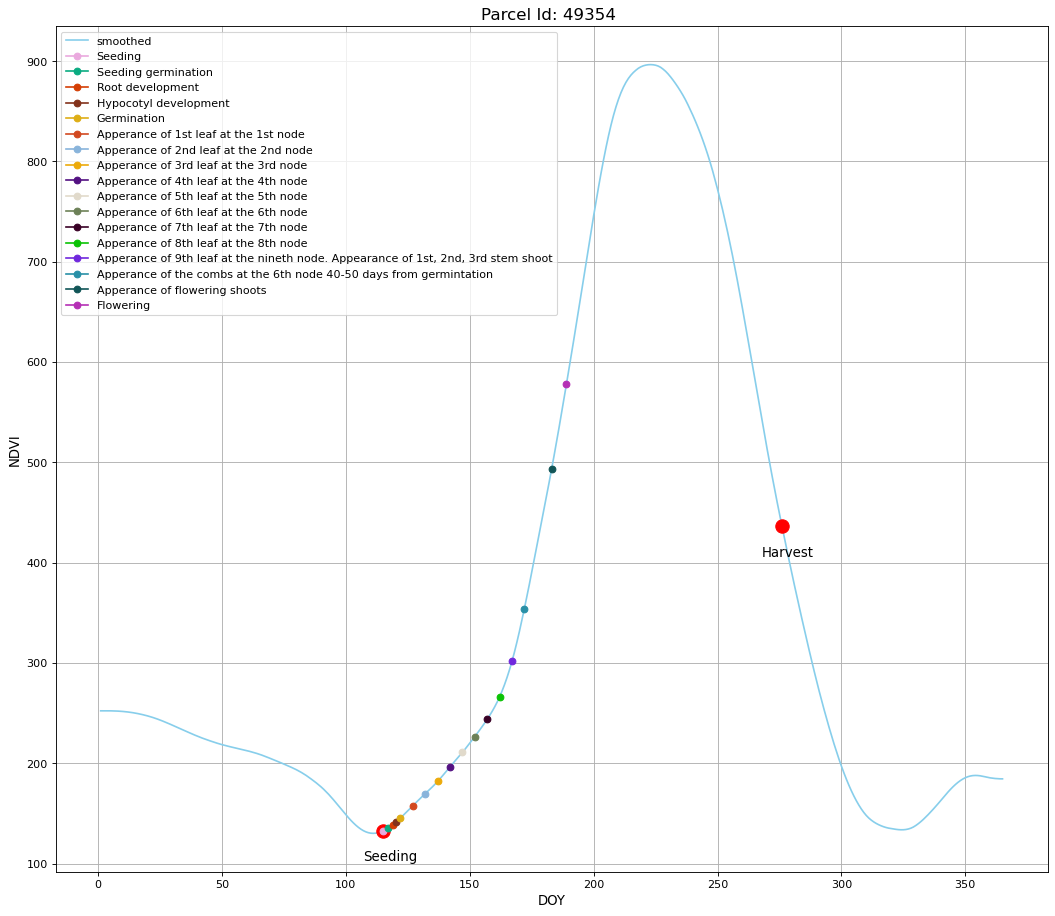

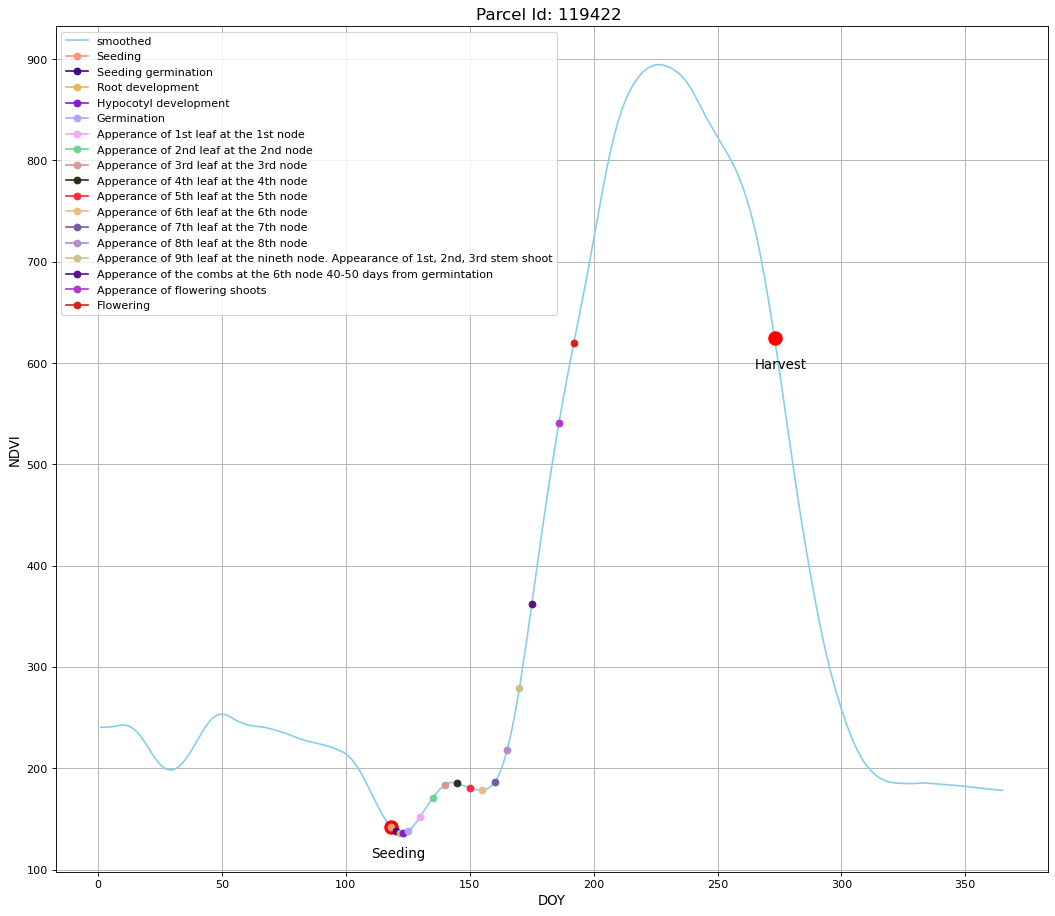

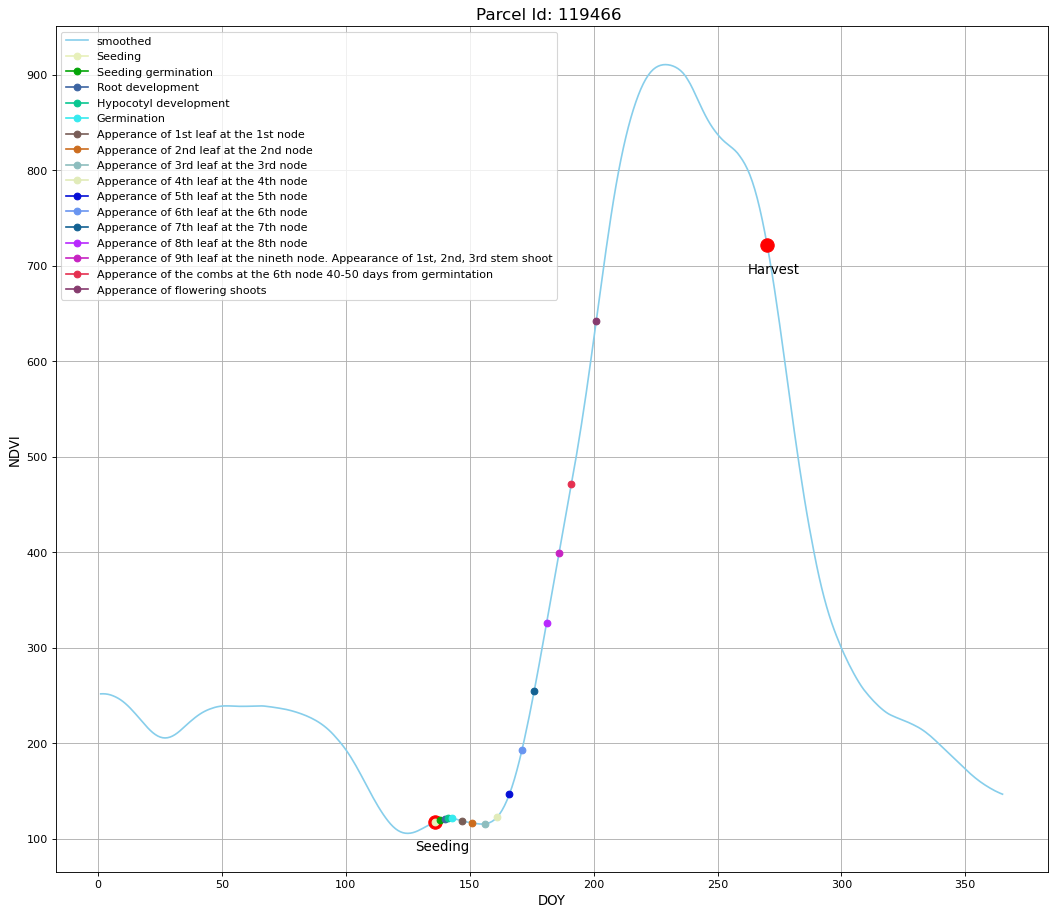

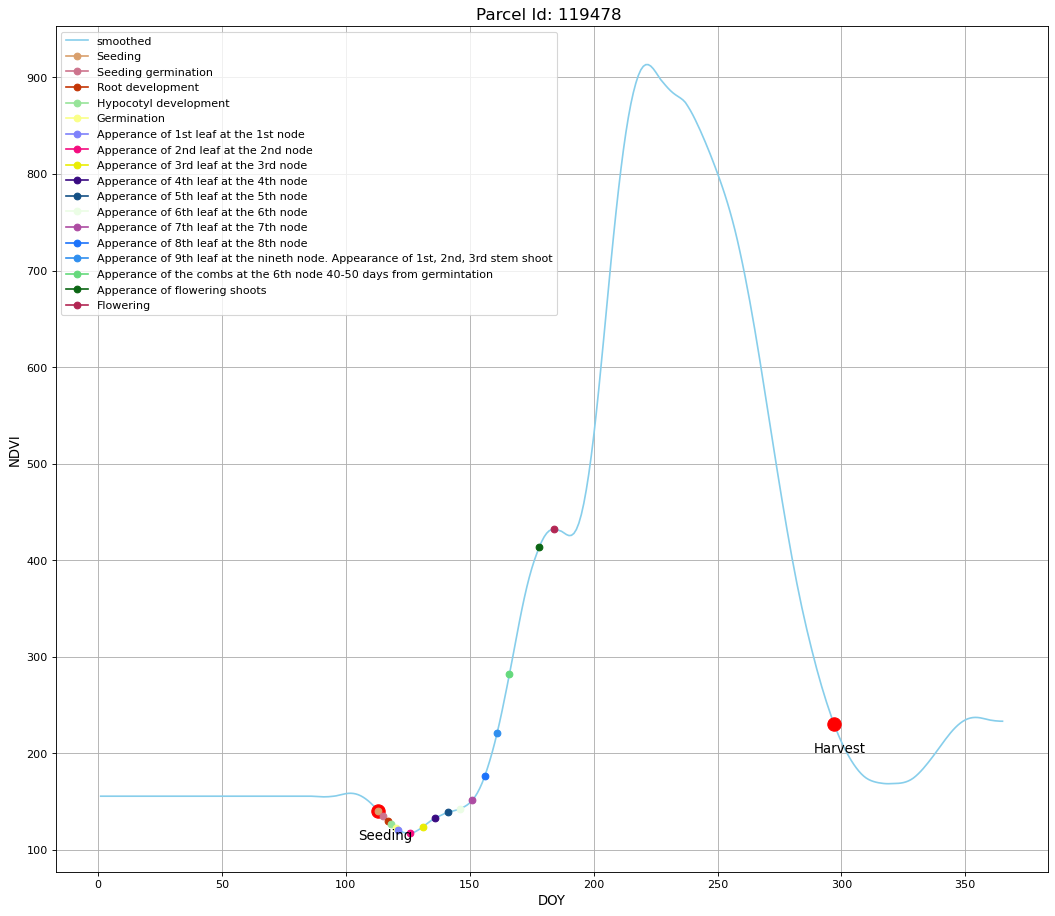

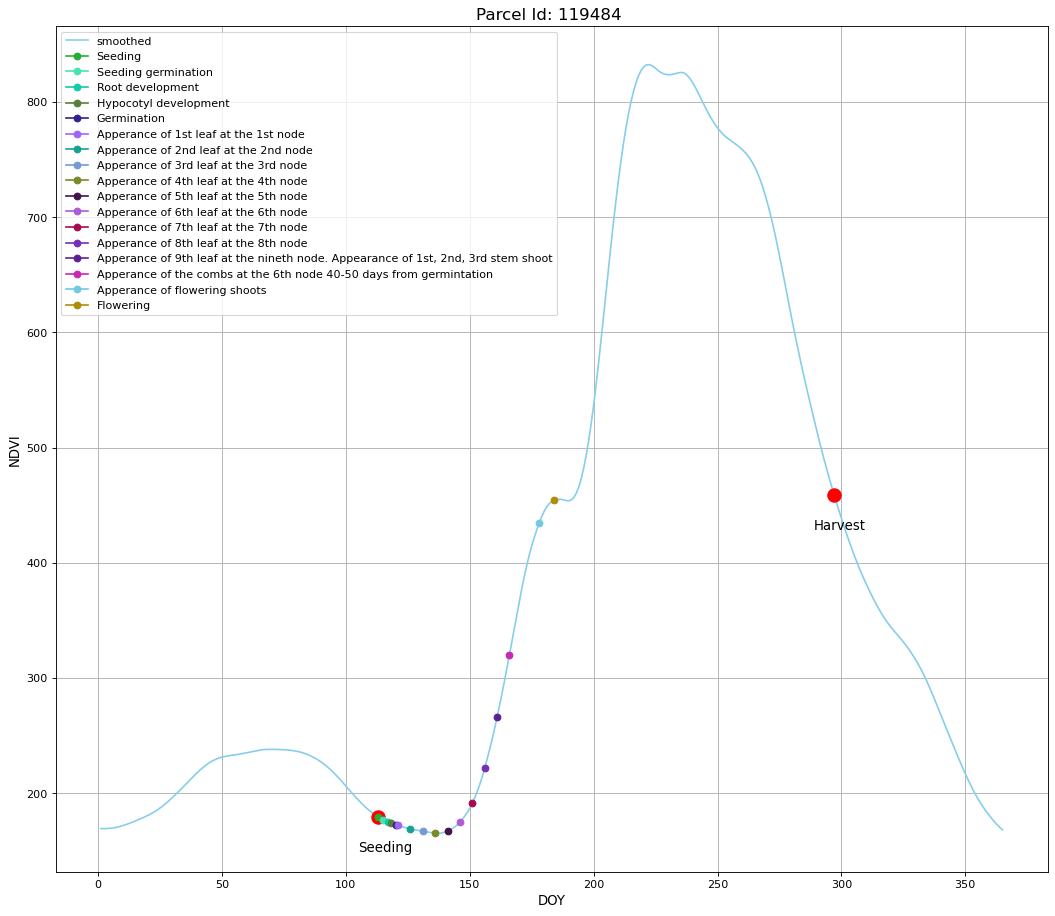

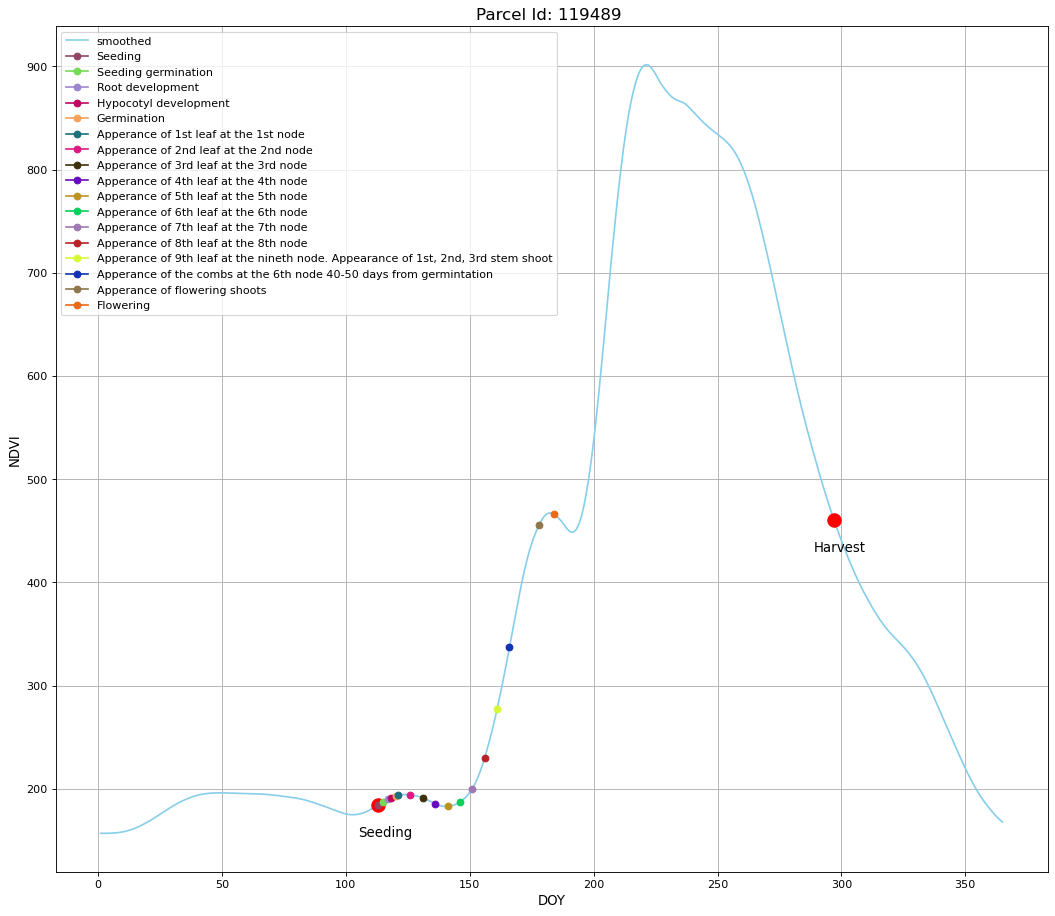

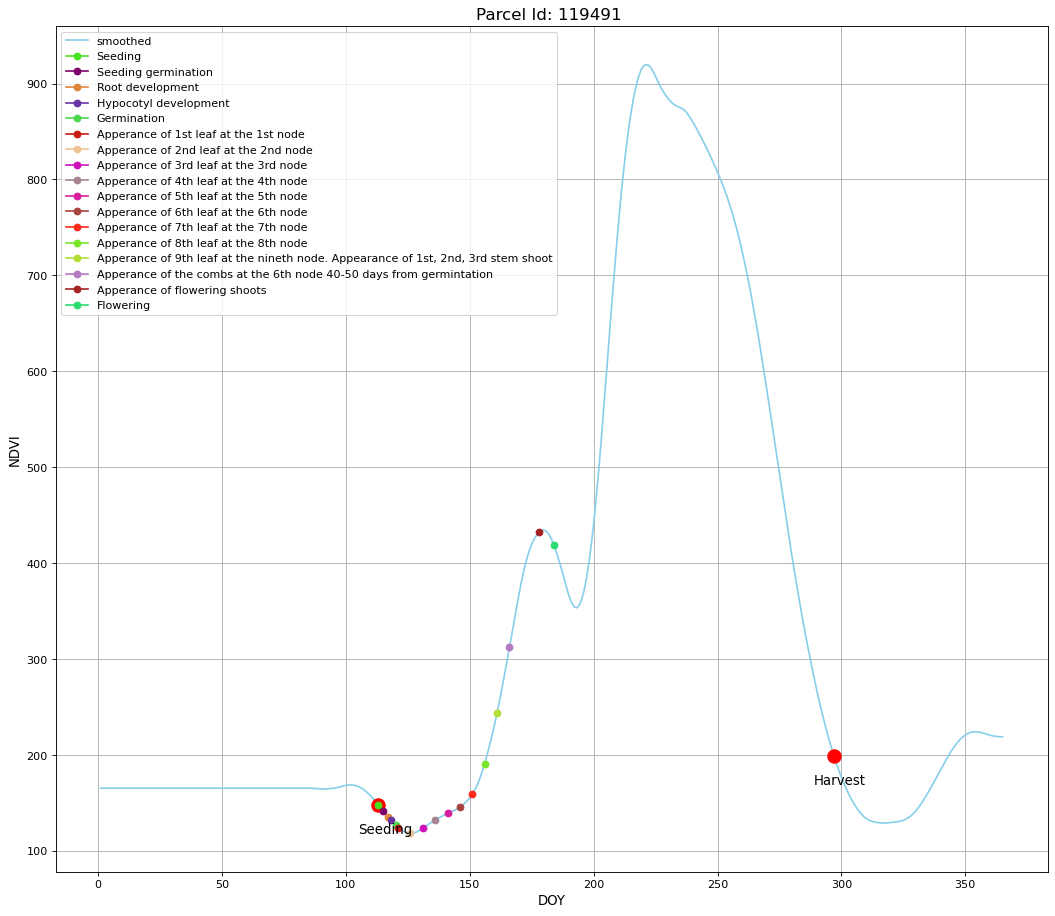

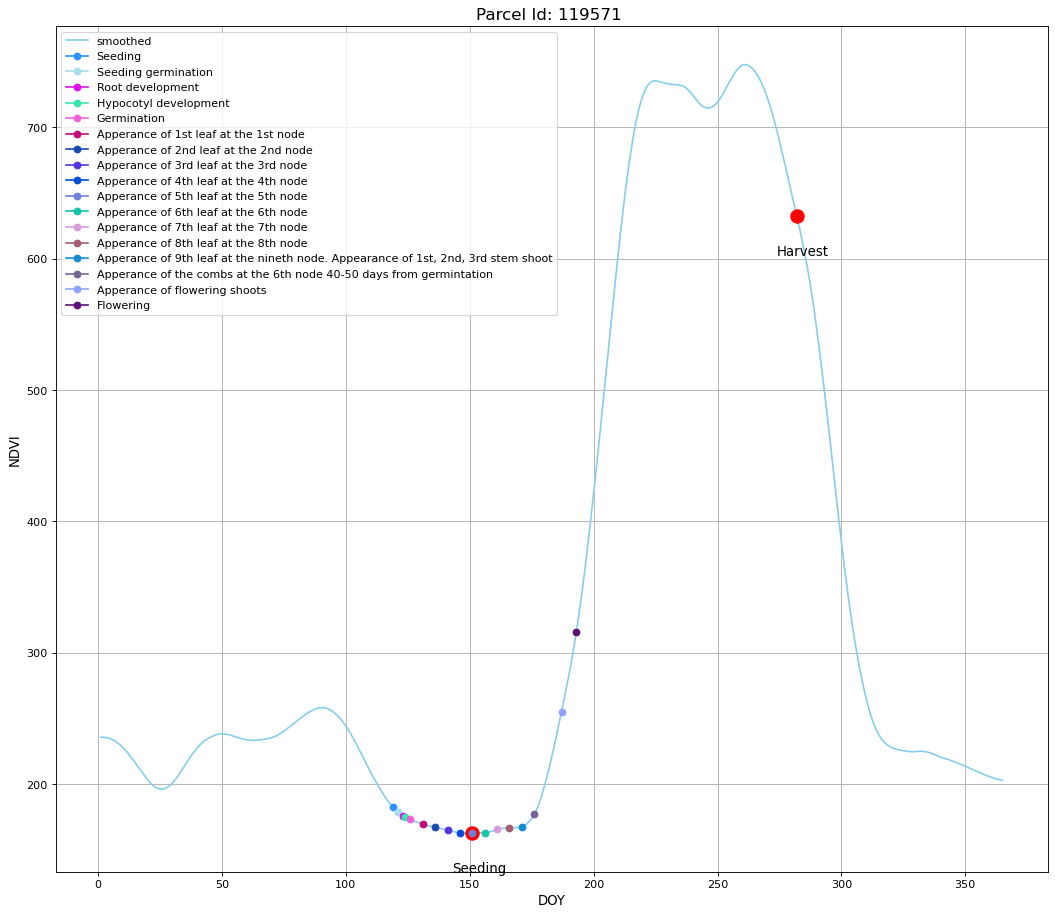

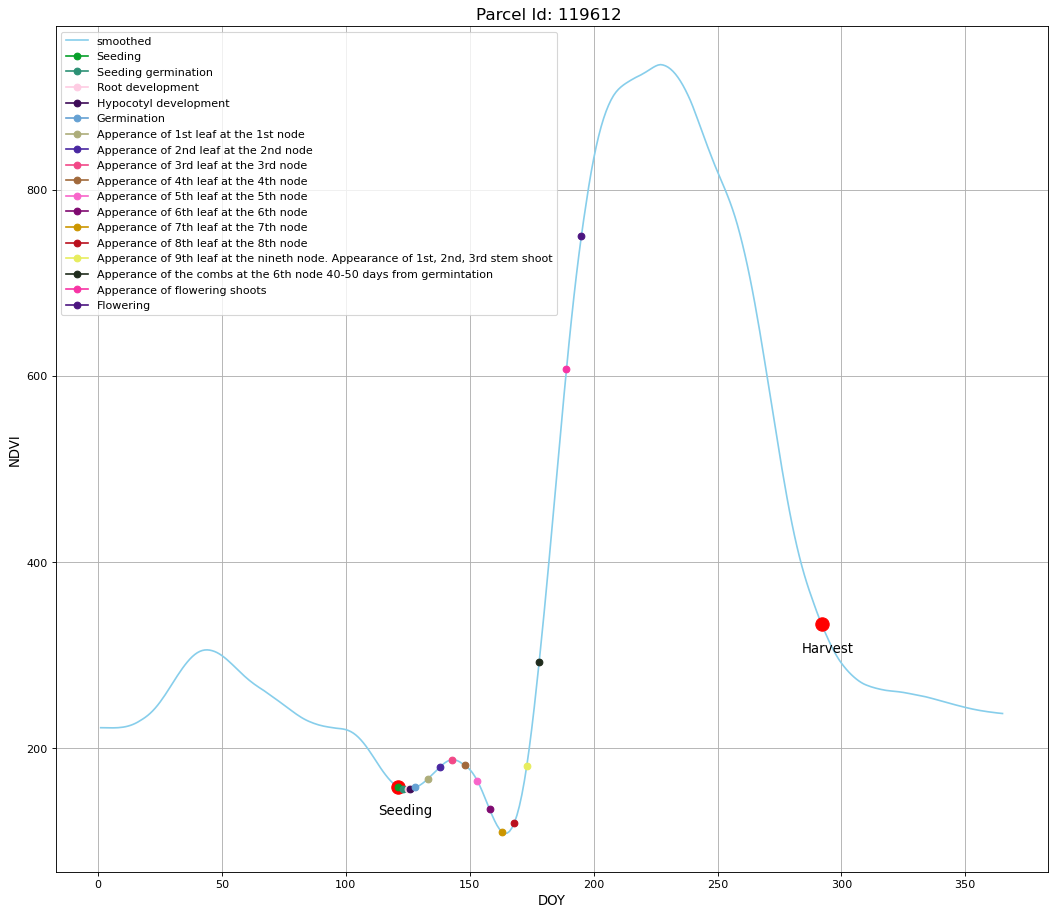

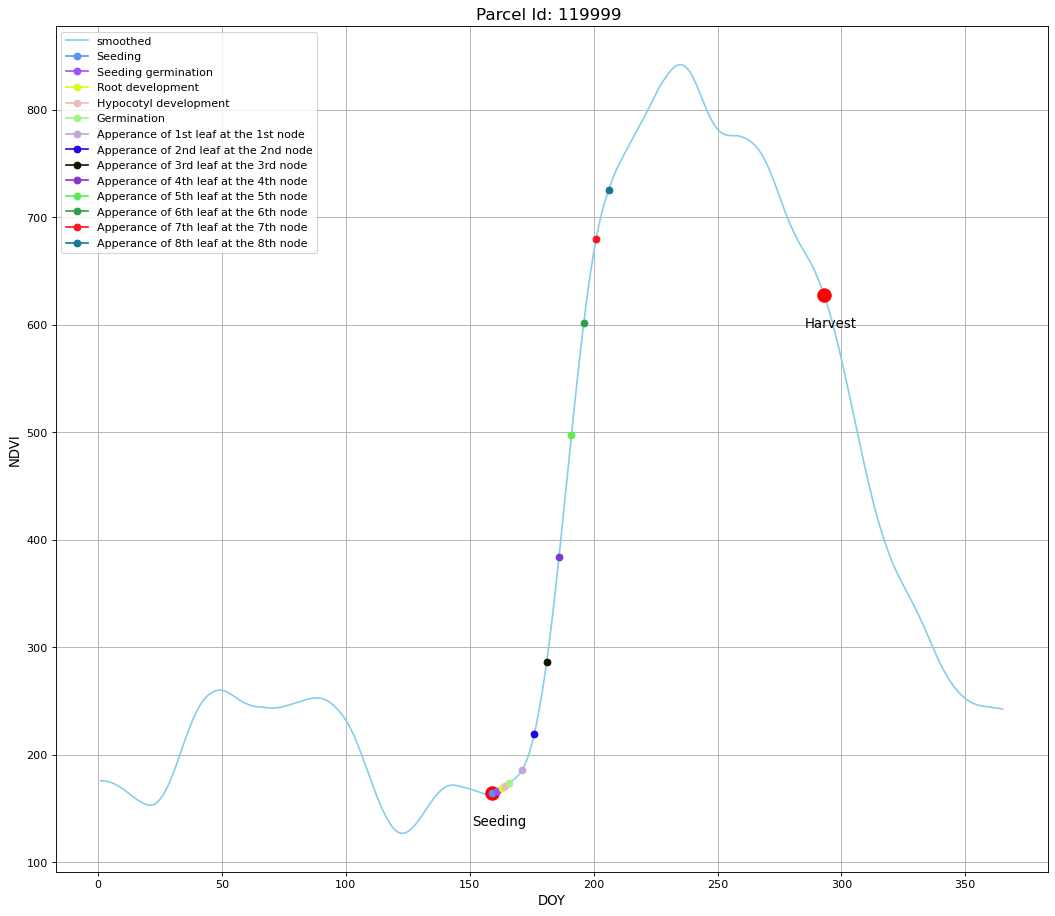

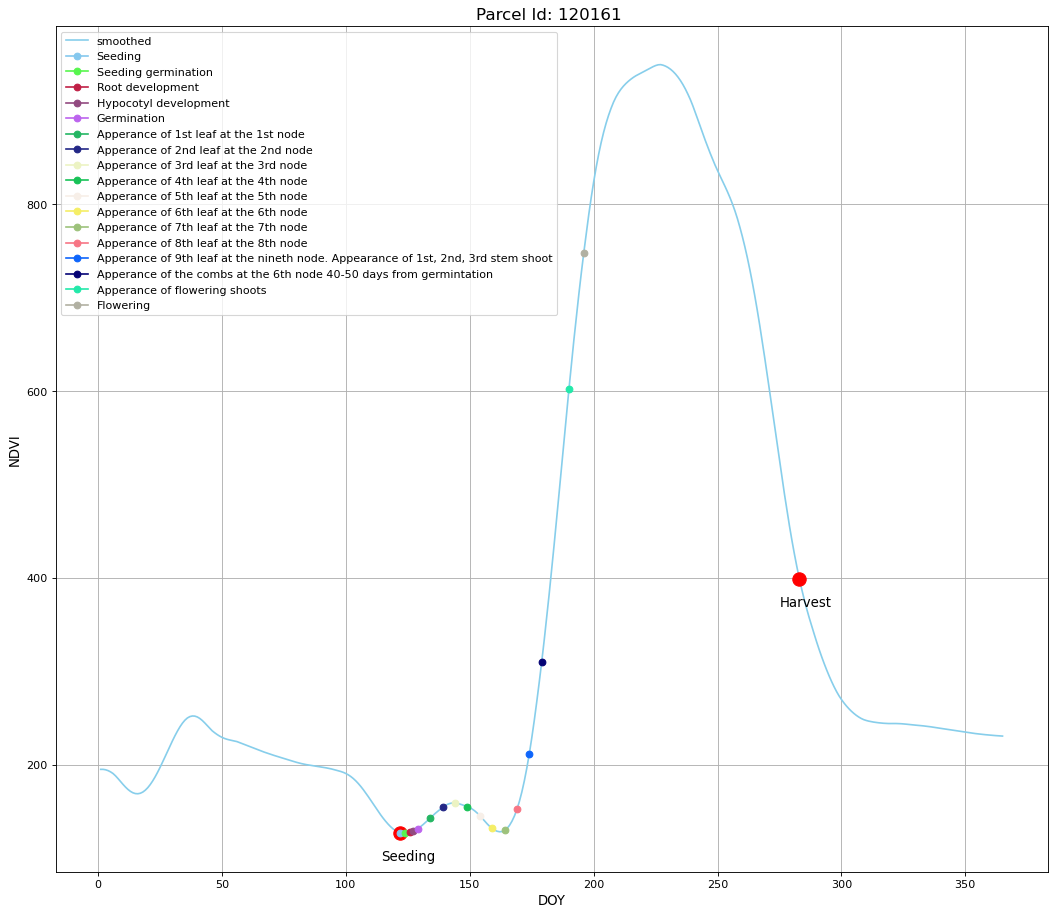

In [228]:
for a in ndvi.columns:
    #a = ndvi.columns[k]
    df1 = ndvi.loc[:,a]

    plt.figure(num=None, figsize=(16,14), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(df1, marker=None, markerfacecolor='skyblue', color='skyblue', label='smoothed')

    plt.plot(validation.loc[a,:].seeding, np.array(ndvi.loc[ndvi.index == validation.loc[a,:].seeding,a])[0], marker='o', markersize=12, color='red')
    plt.text(validation.loc[a,:].seeding-8,np.array(ndvi.loc[ndvi.index == validation.loc[a,:].seeding,a])[0]-30,'Seeding',fontsize=12)

    for i in range (valid_full[valid_full.parc_id==a].shape[0]):
        plt.plot(valid_full[valid_full.parc_id==a].doy.iloc[i], valid_full[valid_full.parc_id==a].ndvi_val.iloc[i], marker='o', color= np.random.rand(3), label=valid_full[valid_full.parc_id==a].scsd_description_en.iloc[i])

    plt.plot(validation.loc[a,:].harvest, np.array(ndvi.loc[ndvi.index == validation.loc[a,:].harvest,a])[0], marker='o',markersize=12, color='red')
    plt.text(validation.loc[a,:].harvest-8,np.array(ndvi.loc[ndvi.index == validation.loc[a,:].harvest,a])[0]-30,'Harvest',fontsize=12)

    plt.grid()

    plt.xlabel('DOY',fontsize=12)
    plt.ylabel('NDVI',fontsize=12)
    plt.legend(loc='upper left')
    plt.title('Parcel Id: {} '.format(a), fontsize=15)

In [59]:
dataset = pd.concat([pheno_metrics.loc[np.intersect1d(validation.index,pheno_metrics.index),:],validation],axis=1)

In [60]:
# ndvi = savitzky.copy()
# ndvi.columns = (np.array(obj_ids))

In [61]:
l=list()
for i in range(1,ndvi.shape[0]+1):
    l.append('NDVI_DOY%s'%i)
ndvi.index = np.asarray(l)

In [62]:
dataset = pd.concat([ndvi.T.loc[np.intersect1d(ndvi.T.index,dataset.index),:],dataset],axis=1)

In [63]:
parcels_meteo = pd.read_csv('C:/Users/antonkout/Documents/Work/antonkoutpersolnal/parcels_AGGD.csv',header=0)
parcels_meteo = parcels_meteo.iloc[:,1:]
parcels_meteo.columns = parcels_meteo.columns.astype(int)
l=list()
for i in range(1,ndvi.shape[0]+1):
    l.append('AGDD_DOY%s'%i)
parcels_meteo.index = np.asarray(l)

In [64]:
dataset = pd.concat([parcels_meteo.T.loc[np.intersect1d(np.array(parcels_meteo.T.index),dataset.index),:],dataset],axis=1)

In [65]:
data_ndwi_psri = pd.read_csv('C:/Users/antonkout/Documents/Work/antonkoutpersolnal/data_ndwi_psri.csv',header=0)
data_ndwi_psri.index = np.asarray(data_ndwi_psri.iloc[:,0])
data_ndwi_psri = data_ndwi_psri.iloc[:,1:]

In [66]:
dataset = pd.concat([data_ndwi_psri.loc[np.intersect1d(np.array(data_ndwi_psri.index),dataset.index),:],dataset],axis=1)

In [744]:
dataset.to_csv('C:/Users/antonkout/Documents/Work/antonkoutpersolnal/dataset.csv')